# Bikeshare rides (Winter 2018)
This notebook analyzes bikeshare data for NYC citibikes. 

Here we get some of the bike data (Jan - Mar of 2018) as a sample set and perform some basic exploratory analysis and plot-making

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import mplleaflet
import pandas as pd
import numpy as np
import json
import math
from matplotlib import cm

import os

os.environ['PROJ_LIB'] = r'C:\Users\pgsze\Anaconda3\pkgs\proj4-5.2.0-ha925a31_1\Library\share'


from mpl_toolkits.basemap import Basemap


In [2]:
#Grab the data for winder 2018
winter_df_list = []

for el in ['01','02','03']:
    winter_df_list.append(pd.read_csv('../data/NYC/2018/2018{}-citibike-tripdata/2018{}-citibike-tripdata.csv'.format(el,el)))

winter_df_list[0].head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,970,2018-01-01 13:50:57.4340,2018-01-01 14:07:08.1860,72,W 52 St & 11 Ave,40.767272,-73.993929,505,6 Ave & W 33 St,40.749013,-73.988484,31956,Subscriber,1992,1
1,723,2018-01-01 15:33:30.1820,2018-01-01 15:45:33.3410,72,W 52 St & 11 Ave,40.767272,-73.993929,3255,8 Ave & W 31 St,40.750585,-73.994685,32536,Subscriber,1969,1
2,496,2018-01-01 15:39:18.3370,2018-01-01 15:47:35.1720,72,W 52 St & 11 Ave,40.767272,-73.993929,525,W 34 St & 11 Ave,40.755942,-74.002116,16069,Subscriber,1956,1
3,306,2018-01-01 15:40:13.3720,2018-01-01 15:45:20.1910,72,W 52 St & 11 Ave,40.767272,-73.993929,447,8 Ave & W 52 St,40.763707,-73.985162,31781,Subscriber,1974,1
4,306,2018-01-01 18:14:51.5680,2018-01-01 18:19:57.6420,72,W 52 St & 11 Ave,40.767272,-73.993929,3356,Amsterdam Ave & W 66 St,40.774667,-73.984706,30319,Subscriber,1992,1


In [3]:
#Concat them all together into one dataframe
winter_df = pd.concat(winter_df_list,ignore_index=True)
winter_df.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,970,2018-01-01 13:50:57.4340,2018-01-01 14:07:08.1860,72,W 52 St & 11 Ave,40.767272,-73.993929,505,6 Ave & W 33 St,40.749013,-73.988484,31956,Subscriber,1992,1
1,723,2018-01-01 15:33:30.1820,2018-01-01 15:45:33.3410,72,W 52 St & 11 Ave,40.767272,-73.993929,3255,8 Ave & W 31 St,40.750585,-73.994685,32536,Subscriber,1969,1
2,496,2018-01-01 15:39:18.3370,2018-01-01 15:47:35.1720,72,W 52 St & 11 Ave,40.767272,-73.993929,525,W 34 St & 11 Ave,40.755942,-74.002116,16069,Subscriber,1956,1
3,306,2018-01-01 15:40:13.3720,2018-01-01 15:45:20.1910,72,W 52 St & 11 Ave,40.767272,-73.993929,447,8 Ave & W 52 St,40.763707,-73.985162,31781,Subscriber,1974,1
4,306,2018-01-01 18:14:51.5680,2018-01-01 18:19:57.6420,72,W 52 St & 11 Ave,40.767272,-73.993929,3356,Amsterdam Ave & W 66 St,40.774667,-73.984706,30319,Subscriber,1992,1


In [4]:
# Comments: 
# The max value for tripduration, there are several trips that are unreasonably long (10^6 seconds is more than 10 days)
# The max latitudes are over 45 degrees! That's not even in New York!
# The min birthyear is 1885! We'll leave these since we can filter out the anomalous ages later if we want to look at age data
winter_df[['tripduration','birth year','start station latitude','start station longitude','end station latitude','end station longitude']].describe().round(2)

,tripduration,birth year,start station latitude,start station longitude,end station latitude,end station longitude
count,2538780.00,2538780.00,2538780.00,2538780.00,2538780.00,2538780.00
mean,864.84,1977.94,40.74,-73.98,40.74,-73.98
std,31231.93,12.09,0.04,0.02,0.04,0.02
min,61.00,1885.00,40.65,-74.02,40.65,-74.06
25%,321.00,1969.00,40.72,-73.99,40.72,-73.99
50%,521.00,1980.00,40.74,-73.99,40.74,-73.99
75%,875.00,1988.00,40.76,-73.97,40.76,-73.98
max,19510049.00,2002.00,45.51,-73.57,45.51,-73.57


In [5]:
#Number of weekend days and weekday days for Jan - March 2018
num_WE = 25
num_WD = 31+28+31-num_WE #Note I'm not subtracting holidays here, maybe later...

The next few cells use the functions in `bike_share_functions.py` to clean the bike data and assemble an independent station dataframe. Finally, pickled versions of the dataframes are saved to disk.

In [6]:
import sys
sys.path.append('../')

from bike_share_functions import bike_clean_df, get_stations_info, get_trip_info


In [7]:
#Cleans data, see output
subs_df = bike_clean_df(winter_df)
print('Total trips remaining: {}'.format(len(subs_df)))

Dropped 0 NaN entries
Dropped an additional 114501 non-subscriber entries
Dropped an additional 1984 entries with trips longer than 2 hours
Changed type of start station id and end station id to integer
Changed type of starttime and stoptime to datetime
Dropped an additional 44 trips with start/end stations outside NYC
Total trips remaining: 2422251


In [8]:
#Creates an independent dataframe with station names and locations
stations_info_df = get_stations_info(subs_df)
print('total stations: {}'.format(len(stations_info_df))) # get the number of stations
stations_info_df.head()

total stations: 777


,lat,lon,station name
72,40.767272,-73.993929,W 52 St & 11 Ave
79,40.719116,-74.006667,Franklin St & W Broadway
82,40.711174,-74.000165,St James Pl & Pearl St
83,40.683826,-73.976323,Atlantic Ave & Fort Greene Pl
119,40.696089,-73.978034,Park Ave & St Edwards St


In [9]:
#get_trip_info removes some redundant station info from subs_df and also creates some new columns
subs_trips_df = get_trip_info(subs_df)

subs_trips_df.head()

,tripduration,starttime,stoptime,start station id,end station id,bikeid,birth year,gender,start_day,stop_day,pickup_hour,dropoff_hour,age,Trip_Type,start_end_station
0,970,2018-01-01 13:50:57.434,2018-01-01 14:07:08.186,72,505,31956,1992,1,0,0,13,14,26,Midday,"(72, 505)"
1,723,2018-01-01 15:33:30.182,2018-01-01 15:45:33.341,72,3255,32536,1969,1,0,0,15,15,49,Midday,"(72, 3255)"
2,496,2018-01-01 15:39:18.337,2018-01-01 15:47:35.172,72,525,16069,1956,1,0,0,15,15,62,Midday,"(72, 525)"
3,306,2018-01-01 15:40:13.372,2018-01-01 15:45:20.191,72,447,31781,1974,1,0,0,15,15,44,Midday,"(72, 447)"
4,306,2018-01-01 18:14:51.568,2018-01-01 18:19:57.642,72,3356,30319,1992,1,0,0,18,18,26,Commuter,"(72, 3356)"


In [ ]:
#Export the results as pickled dateframes for use in other analyses 
winter_df.to_pickle('..data/pickledDFs/NYC_Winter_2018.pkl')
subs_df.to_pickle('../data/pickledDFs/subs_df-NYC_Winter_2018.pkl')
stations_info_df.to_pickle('../data/pickledDFs/stations_info_df-NYC_Winter_2018.pkl')
subs_trips_df.to_pickle('../data/pickledDFs/subs_trips_df-NYC_Winter_2018.pkl')

Now, separate out weekday vs weekend trips and check some details 

In [12]:
#Separate out the weekday and weekend trips
weekday_subs_trips_df = subs_trips_df[subs_trips_df['Trip_Type'] != 'Weekend'].copy()
weekend_subs_trips_df = subs_trips_df[subs_trips_df['Trip_Type'] == 'Weekend'].copy()

In [17]:
winter_df[['tripduration','birth year']].describe().round(2)

,tripduration,birth year
count,2538780.00,2538780.00
mean,864.84,1977.94
std,31231.93,12.09
min,61.00,1885.00
25%,321.00,1969.00
50%,521.00,1980.00
75%,875.00,1988.00
max,19510049.00,2002.00


In [15]:
weekday_subs_trips_df[['tripduration','age']].describe().round(2)

,tripduration,age
count,1925298.00,1925298.00
mean,650.46,40.07
std,494.49,12.14
min,61.00,16.00
25%,316.00,30.00
50%,506.00,38.00
75%,824.00,49.00
max,7186.00,133.00


In [16]:
weekend_subs_trips_df[['tripduration','age']].describe().round(2)

,tripduration,age
count,496953.00,496953.00
mean,668.36,38.83
std,545.62,12.30
min,61.00,16.00
25%,307.00,29.00
50%,500.00,36.00
75%,844.00,48.00
max,7164.00,133.00


In [22]:
print('total weekday trips: {}'.format(len(weekday_subs_trips_df)))
print('total weekend trips: {}'.format(len(weekend_subs_trips_df)))
print('Sum: {}'.format(len(weekend_subs_trips_df)+len(weekday_subs_trips_df)))

total weekday trips: 1925298
total weekend trips: 496953
Sum: 2422251


The following are just simple plots of various aspects of the data. 

The first two are total trip counts per hour for weekday and weekend.

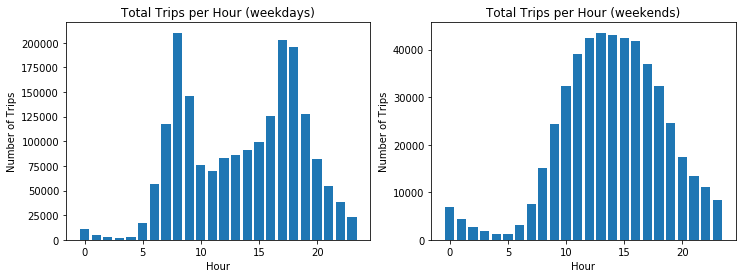

In [40]:
#Total trips (= num pickups) by hour (weekday)
fig, ax= plt.subplots(1,2,figsize = (12,4)) 


WD_total_rides_by_hour = weekday_subs_trips_df.groupby('pickup_hour')['starttime'].count()

ax[0].bar(WD_total_rides_by_hour.index,WD_total_rides_by_hour)
ax[0].set_title('Total Trips per Hour (weekdays)')
ax[0].set_xlabel('Hour')
ax[0].set_ylabel('Number of Trips')

WE_total_rides_by_hour = weekend_subs_trips_df.groupby('pickup_hour')['starttime'].count()

ax[1].bar(WE_total_rides_by_hour.index,WE_total_rides_by_hour)
ax[1].set_title('Total Trips per Hour (weekends)')
ax[1].set_xlabel('Hour')
ax[1].set_ylabel('Number of Trips');

Text(0, 0.5, 'Number of Trips')

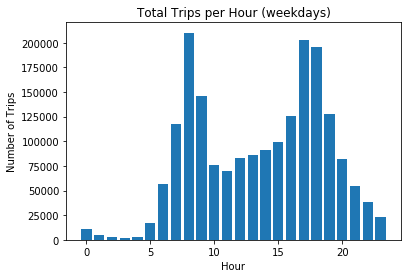

In [23]:
#Total trips (= num pickups) by hour (weekday)
fig = plt.figure()
ax = fig.gca()

total_rides_by_hour = weekday_subs_trips_df.groupby('pickup_hour')['starttime'].count()

ax.bar(total_rides_by_hour.index,total_rides_by_hour)
ax.set_title('Total Trips per Hour (weekdays)')
ax.set_xlabel('Hour')
ax.set_ylabel('Number of Trips')



Text(0.5, 1.0, 'Total Trips per Hour (weekends)')

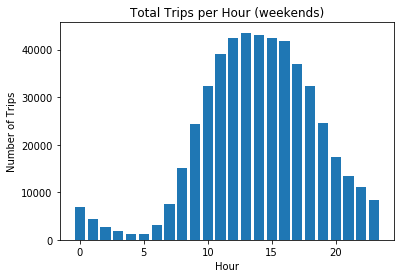

In [24]:
#Total trips by hour (weekend)
fig = plt.figure()
ax = fig.gca()

total_rides_by_hour = weekend_subs_trips_df.groupby('pickup_hour')['starttime'].count()

ax.bar(total_rides_by_hour.index,total_rides_by_hour)

ax.set_xlabel('Hour')
ax.set_ylabel('Number of Trips')

ax.set_title('Total Trips per Hour (weekends)')

Now we plot the same for a single station, choosing the station with the most total trips (for weekdays and weekends, respectively)

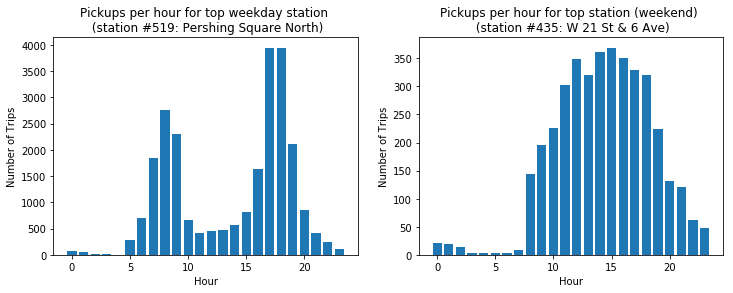

In [41]:
fig, ax= plt.subplots(1,2,figsize = (12,4)) 


WD_total_rides_by_hr_st = weekday_subs_trips_df.groupby(['pickup_hour','start station id'])['tripduration'].count()
WD_total_rides_by_hr_st = WD_total_rides_by_hr_st.rename('total_trips') 

#max_pu_st = total_rides_by_hr_st.idxmax()[1]
WD_max_pu_st = weekday_subs_trips_df.groupby(['start station id'])['tripduration'].count().idxmax()

WD_top_pu_station = WD_total_rides_by_hr_st.loc[:,WD_max_pu_st]

WE_total_rides_by_hr_st = weekend_subs_trips_df.groupby(['pickup_hour','start station id'])['tripduration'].count()
WE_total_rides_by_hr_st = WE_total_rides_by_hr_st.rename('total_trips') 

#max_pu_st = total_rides_by_hr_st.idxmax()[1]
WE_max_pu_st = weekend_subs_trips_df.groupby(['start station id'])['tripduration'].count().idxmax()

WE_top_pu_station = WE_total_rides_by_hr_st.loc[:,WE_max_pu_st]


ax[0].bar(WD_top_pu_station.index,WD_top_pu_station)
#ax.set_title('Pickups per hour for top (hourly) station (weekday)')
ax[0].set_title('Pickups per hour for top weekday station \n (station #{}: {})'.format(WD_max_pu_st,stations_info_df.loc[WD_max_pu_st]['station name']))
ax[0].set_xlabel('Hour')
ax[0].set_ylabel('Number of Trips')

ax[1].bar(WE_top_pu_station.index,WE_top_pu_station)
#ax.set_title('Pickups per hour for top (hourly) weekend station')
ax[1].set_title('Pickups per hour for top station (weekend) \n (station #{}: {})'.format(WE_max_pu_st,stations_info_df.loc[WE_max_pu_st]['station name']))
ax[1].set_xlabel('Hour')
ax[1].set_ylabel('Number of Trips');


Plots of average trip duration by hour for weekdays and weekends

Text(0.5, 1.0, 'Average trip duration by hour (weekend)')

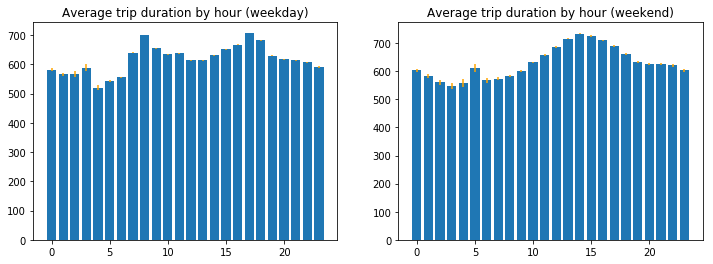

In [42]:
fig, ax= plt.subplots(1,2,figsize = (12,4)) 


WD_avg_duration_by_hour = weekday_subs_trips_df.groupby('pickup_hour')['tripduration'].mean()
WD_total_rides_by_hour = weekday_subs_trips_df.groupby('pickup_hour')['tripduration'].count()
WD_yerror = weekday_subs_trips_df.groupby('pickup_hour')['tripduration'].std()/(WD_total_rides_by_hour)**(1/2)

ax[0].bar(WD_avg_duration_by_hour.index,WD_avg_duration_by_hour, yerr=WD_yerror,ecolor = 'orange')
ax[0].set_title('Average trip duration by hour (weekday)')

WE_avg_duration_by_hour = weekend_subs_trips_df.groupby('pickup_hour')['tripduration'].mean()
WE_total_rides_by_hour = weekend_subs_trips_df.groupby('pickup_hour')['tripduration'].count()
WE_yerror = weekend_subs_trips_df.groupby('pickup_hour')['tripduration'].std()/(WE_total_rides_by_hour)**(1/2)

ax[1].bar(WE_avg_duration_by_hour.index,WE_avg_duration_by_hour, yerr=WE_yerror,ecolor = 'orange')
ax[1].set_title('Average trip duration by hour (weekend)')

Plots of average age by hour

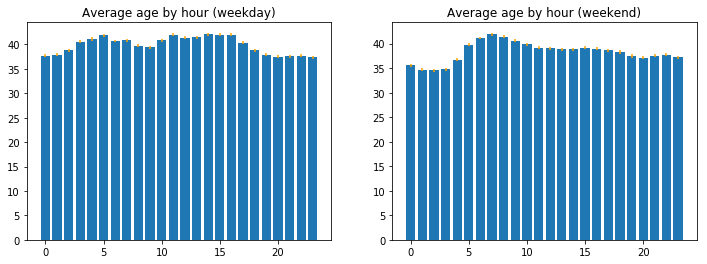

In [44]:
fig, ax= plt.subplots(1,2,figsize = (12,4)) 

WD_avg_age_by_hour = weekday_subs_trips_df.groupby('pickup_hour')['age'].mean()

WD_total_rides_by_hour = weekday_subs_trips_df.groupby('pickup_hour')['age'].count()
WD_yerror = weekday_subs_trips_df.groupby('pickup_hour')['age'].std()/WD_avg_age_by_hour #Relative standard deviation instead of std dev of mean

ax[0].bar(WD_avg_age_by_hour.index,WD_avg_age_by_hour,yerr=WD_yerror, ecolor='orange')
ax[0].set_title('Average age by hour (weekday)')

WE_avg_age_by_hour = weekend_subs_trips_df.groupby('pickup_hour')['age'].mean()

WE_total_rides_by_hour = weekend_subs_trips_df.groupby('pickup_hour')['age'].count()
WE_yerror = weekend_subs_trips_df.groupby('pickup_hour')['age'].std()/WE_avg_age_by_hour #Relative standard deviation instead of std dev of mean

ax[1].bar(WE_avg_age_by_hour.index,WE_avg_age_by_hour,yerr=WE_yerror, ecolor='orange')
ax[1].set_title('Average age by hour (weekend)');

Trip duration histograms

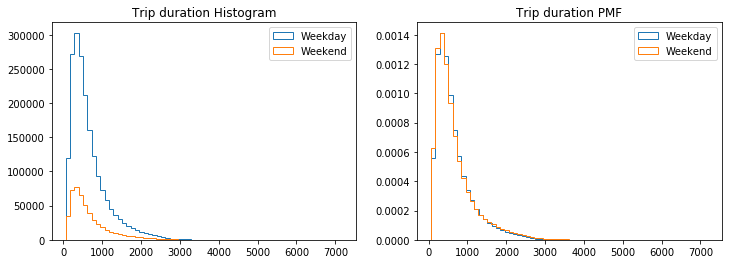

In [70]:
fig, ax = plt.subplots(1,2,figsize=(12,4))

#duration_by_hour = weekday_subs_trips_df.groupby('pickup_hour')['tripduration']

plt.sca(ax[0])
weekday_subs_trips_df['tripduration'].hist(bins=64,histtype='step')
weekend_subs_trips_df['tripduration'].hist(bins=64,histtype='step')

ax[0].grid(False)
ax[0].legend(['Weekday', 'Weekend'])
ax[0].set_title('Trip duration Histogram');

plt.sca(ax[1])
weekday_subs_trips_df['tripduration'].hist(bins=64,histtype='step',density=True)
weekend_subs_trips_df['tripduration'].hist(bins=64,histtype='step',density=True)
ax[1].grid(False)
ax[1].legend(['Weekday', 'Weekend'])
ax[1].set_title('Trip duration PMF');

#
#fig = plt.figure()
#ax = fig.gca()
#
#weekday_subs_trips_df['tripduration'].hist(bins=64,histtype='step')
#weekend_subs_trips_df['tripduration'].hist(bins=64,histtype='step')
#ax.grid(False)
#ax.legend(['Weekday', 'Weekend'])
#ax.set_title('Trip duration histogram')

Hourly trip duration histograms, all follow roughly the same distribution

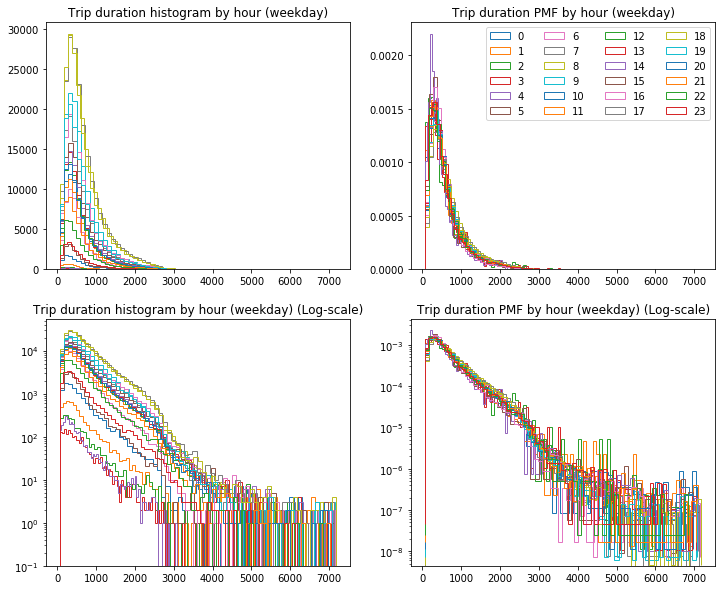

In [71]:
fig, ax = plt.subplots(2,2,figsize=(12,10))

duration_by_hour = weekday_subs_trips_df.groupby('pickup_hour')['tripduration']

plt.sca(ax[0,0])
duration_by_hour.hist(bins=64,histtype ='step')

plt.sca(ax[0,1])
duration_by_hour.hist(bins=64,histtype ='step',density=True)

plt.sca(ax[1,0])
duration_by_hour.hist(bins=64,histtype ='step',log=True)

plt.sca(ax[1,1])
duration_by_hour.hist(bins=64,histtype ='step',density=True,log=True)

ax[0,0].set_title('Trip duration histogram by hour (weekday)')
ax[0,0].grid(False)


ax[0,1].set_title('Trip duration PMF by hour (weekday)')
ax[0,1].grid(False)

ax[1,0].set_title('Trip duration histogram by hour (weekday) (Log-scale)')
ax[1,0].grid(False)


ax[1,1].set_title('Trip duration PMF by hour (weekday) (Log-scale)')
ax[1,1].grid(False)

ax[0,1].legend(labels = list(range(24)),ncol=4)

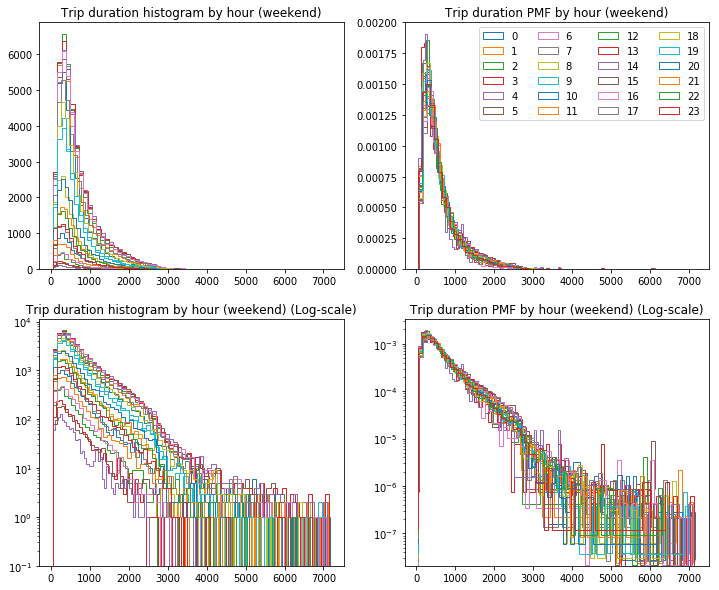

In [72]:
fig, ax = plt.subplots(2,2,figsize=(12,10))

duration_by_hour = weekend_subs_trips_df.groupby('pickup_hour')['tripduration']

plt.sca(ax[0,0])
duration_by_hour.hist(bins=64,histtype ='step')

plt.sca(ax[0,1])
duration_by_hour.hist(bins=64,histtype ='step',density=True)

plt.sca(ax[1,0])
duration_by_hour.hist(bins=64,histtype ='step',log=True)

plt.sca(ax[1,1])
duration_by_hour.hist(bins=64,histtype ='step',density=True,log=True)

ax[0,0].set_title('Trip duration histogram by hour (weekend)')
ax[0,0].grid(False)


ax[0,1].set_title('Trip duration PMF by hour (weekend)')
ax[0,1].grid(False)

ax[1,0].set_title('Trip duration histogram by hour (weekend) (Log-scale)')
ax[1,0].grid(False)


ax[1,1].set_title('Trip duration PMF by hour (weekend) (Log-scale)')
ax[1,1].grid(False)

ax[0,1].legend(labels = list(range(24)),ncol=4)

Histogram of ages

Text(0.5, 1.0, 'Age histogram (weekday)')

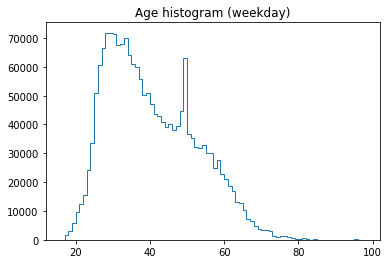

In [73]:
fig = plt.figure()
ax = fig.gca()


ages_series  = weekday_subs_trips_df[weekday_subs_trips_df['age'] < 100]['age']
#duration_by_hour = short_weekend_subs_trips_df.groupby('pickup_hour')['tripduration']

ages_series.hist(bins=list([n for n in range(ages_series.min(),ages_series.max())]),histtype='step')
#ax.hist(duration_by_hour)

ax.grid(False)
#ax.bar(avg_duration_by_hour.index,avg_duration_by_hour,yerr=yerror, ecolor='orange')
ax.set_title('Age histogram (weekday)')
#ax.legend(labels = list(range(24)),ncol=4)

In [63]:
#For some reason there are alot of users that are near 50, it turns out 49 is the number with the sharp peak above
ages_series.groupby(by=ages_series).count().nlargest(15)

age
29    71838
28    71622
30    71381
33    69877
32    68088
31    67479
27    66491
34    64270
49    63028
35    60967
26    60544
36    60078
37    55756
25    51039
39    50970
Name: age, dtype: int64

In [65]:
# This is actually less interesting than it would appear, if we look at it in terms of birthyear.... 
# Perhaps we should take the age listings with a grain of salt...
birthyear_series= weekday_subs_trips_df[weekday_subs_trips_df['age'] < 100]['birth year']
birthyear_series.groupby(by=birthyear_series).count().nlargest(15)

birth year
1989    71838
1990    71622
1988    71381
1985    69877
1986    68088
1987    67479
1991    66491
1984    64270
1969    63028
1983    60967
1992    60544
1982    60078
1981    55756
1993    51039
1979    50970
Name: birth year, dtype: int64

Can also consider distribution for individual bike usage (total time)

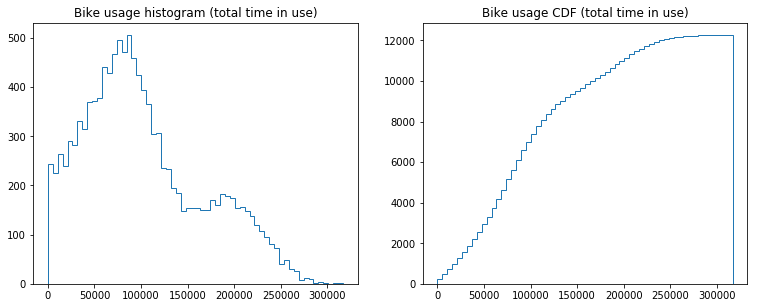

In [66]:
fig = plt.subplots(1,2,figsize=(12.8,4.8))


total_duration_by_bikeid = weekday_subs_trips_df.groupby('bikeid')['tripduration'].sum()


plt.subplot(121)
total_duration_by_bikeid.hist(bins=60,histtype='step')#,density=True)
plt.grid(False)
ax=plt.gca()
ax.set_title('Bike usage histogram (total time in use)')

plt.subplot(122)
total_duration_by_bikeid.hist(bins=60,histtype='step',cumulative=True)
plt.grid(False)
ax=plt.gca()
ax.set_title('Bike usage CDF (total time in use)')

plt.show()



Similar results for total number of trips

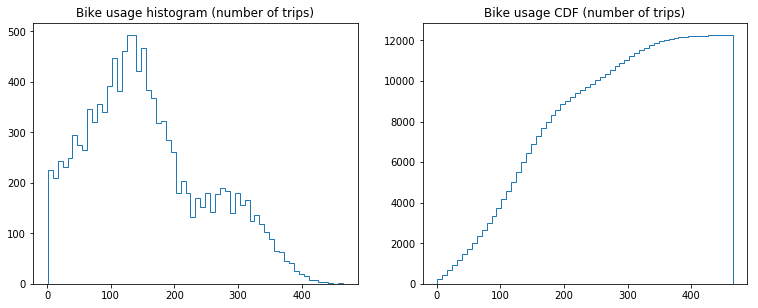

In [68]:
fig = plt.subplots(1,2,figsize=(12.8,4.8))
#ax = fig.gca()

total_trips_by_bikeid = weekday_subs_trips_df.groupby('bikeid')['tripduration'].count()

plt.subplot(121)
total_trips_by_bikeid.hist(bins=60,histtype='step')#,density=True)
plt.grid(False)
ax=plt.gca()
ax.set_title('Bike usage histogram (number of trips)')

plt.subplot(122)
total_trips_by_bikeid.hist(bins=60,histtype='step',cumulative=True)
plt.grid(False)
ax=plt.gca()
ax.set_title('Bike usage CDF (number of trips)')

plt.show()



#ax.set_title('Bike usage histogram (total trips)')
#total_trips_by_bikeid.sort_values(ascending=False).head()

In [41]:


total_duration_by_bikeid.nlargest(10)/60/60/24


bikeid
32090    3.665486
32061    3.627025
30624    3.562755
32173    3.444340
32161    3.373252
31851    3.369861
30692    3.361771
30315    3.347130
33017    3.322500
32180    3.269549
Name: tripduration, dtype: float64

In [69]:
ave_trip_length_by_bikeid = total_duration_by_bikeid.astype(float)/total_trips_by_bikeid.astype(float)/60
#print(ave_trip_length_by_bikeid.mean())
#print(ave_trip_length_by_bikeid.median())
ave_trip_length_by_bikeid.describe().round(2)

count    12253.00
mean        10.71
std          1.43
min          1.02
25%         10.07
50%         10.73
75%         11.34
max         77.63
Name: tripduration, dtype: float64

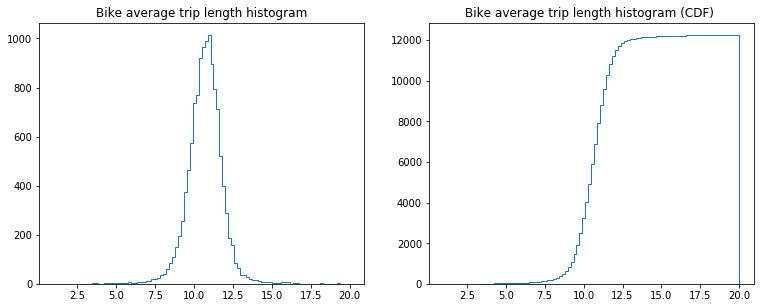

In [71]:
fig, ax = plt.subplots(1,2,figsize=(12.8,4.8))

plt.subplot(121)
ave_trip_length_by_bikeid[ave_trip_length_by_bikeid < 20].hist(bins=100,histtype='step')
plt.grid(False)
ax=plt.gca()
ax.grid(False)
#ax.set_xlim(right=30)
ax.set_title('Bike average trip length histogram');

plt.subplot(122)
ave_trip_length_by_bikeid[ave_trip_length_by_bikeid < 20].hist(bins=100,histtype='step',cumulative=True)
plt.grid(False)
ax=plt.gca()
ax.grid(False)
ax.set_title('Bike average trip length histogram (CDF) ');

In [72]:
print(len(ave_trip_length_by_bikeid[ave_trip_length_by_bikeid < 20]))
print(len(ave_trip_length_by_bikeid))

12239
12253
